In [1]:
# KAGGLE KERNEL
# download vgg19 model mat file
!wget "http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat"
# -P /kaggle/input #(read only folder)

# code to read kaggle file system
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-08-09 10:08:06--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  62.2MB/s    in 9.3s    

2019-08-09 10:08:16 (54.7 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]

/kaggle/input/dlf.jpg
/kaggle/input/city-paint.jpeg
/kaggle/input/galmpton-painting.jpg
/kaggle/input/Lal_quila.jpg
/kaggle/input/Paharganj.jpg
/kaggle/input/delhi.jpg
/kaggle/input/Taj_Mahal.jpeg
/kaggle/input/Rashtrapati-bhavan.jpg


In [2]:
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#import imageio

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 300
COLOR_CHANNELS = 3

####  1. Content image, C => image to put style on
####  2. Style image, S
####  3. Generated image, G => Content image with style of S

Using pretrained model, going to take activation of hidden layer somewhere in the middle of the network as result. And Using custom Cost function going to tune the network, to create a C image with style of S, image G **Using aG activation of dimension (1, nH, nW, nC).

# 1. Defining Cost for the neural netwrok

1. Content cost, JC
2. Style cost, SC
3. Combining the two costs, J

## 1.1 Content Cost, JC

Content cost takes a hidden layer activation for both C and G images, aC and aG, and measure their difference. So, when we minimize this cost, it will make Genrated image G contents similar to C image.

In [5]:
def contentCost(aC, aG):
    """
    Computes the content cost
    
    Arguments:
    aC -- tensor of dimension (1, nH, nW, nC)
    aG -- tensor of dimension (1, nH, nW, nC)
    
    Returns: 
    JC -- cost for the content image
    """
    
    # Retrieve dimensions from a_G
    m, nH, nW, nC = aG.get_shape().as_list()
    
    # Reshape aC and aG
    aC_unrolled = tf.reshape(aC, [m, nH * nW, nC])
    aG_unrolled = tf.reshape(aG, [m, nH * nW, nC])
    
    
    JC = (1 / (4 * nH * nW * nC)) * tf.reduce_sum(tf.square(tf.subtract(aC_unrolled, aG_unrolled)))
        
    return JC

## 1.2 Style Cost, JS

Gram matrix G of a set of vectors (v1,…,vn) is the matrix of dot products

Gij = np.dot(vi,vj)

large Gij means vi is very similar to vj

In [6]:
def gramMatrix(A):
    """
    Argument:
    A -- matrix of shape (nC, nH * nW)
    
    Returns:
    GM -- Gram matrix of A, of shape (nC, nC)
    """
    
    GM = tf.matmul(A, A, transpose_b=True)
    
    return GM

need to minimize the distance between the Gram matrix of the style image S and that of the generated image G.

In [7]:
def styleCost(aS, aG):
    """
    Arguments:
    aS -- tensor of dimension (1, nH, nW, nC)
    aG -- tensor of dimension (1, nH, nW, nC)
    
    Returns: 
    JS -- scalar style cost
    """
    
    m, nH, nW, nC = aG.get_shape().as_list()
    
    # Reshape the images
    # if m images, need to use a for loop
    aS = tf.transpose(tf.reshape(aS, [nH * nW, nC]))
    aG = tf.transpose(tf.reshape(aG, [nH * nW, nC]))

    # Computing gram_matrices for S and G
    GMS = gramMatrix(aS)
    GMG = gramMatrix(aG)
    
    
    # Computing the loss (≈1 line)
    JS = (1 / ((2 * nC * nH * nW) ** 2)) * tf.reduce_sum(tf.square(tf.subtract(GMS, GMG)))
        
    return JS

Can get better results if use style cost from different layers and combine them using weighted average.

In [8]:
layerWeights = [('conv1_1', 0.2),
                ('conv2_1', 0.2),
                ('conv3_1', 0.2),
                ('conv4_1', 0.2),
                ('conv5_1', 0.2)]

In [9]:
def weightedStyleCost(model, layerWeights):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- tensorflow model
    layerWeights -- layers to extract style from with correspinding weights to use
    
    Returns: 
    JS -- weighted style cost
    """
    
    # initialize the overall style cost
    JS = 0

    for layer, w in layerWeights:

        # output tensor of the current layer
        out = model[layer]

        # Set aS to be the hidden layer activation by running the session on out
        aS = sess.run(out)

        # Set aG to be the hidden layer activation from the same layer,
        # going to execute later when we set input as G and run the session
        aG = out
        
        # Compute style_cost for the current layer
        JSlayer = styleCost(aS, aG)

        # Add weighted average to overall style cost
        JS += w * JSlayer

    return JS

Minimizing the weighted style cost will cause the image G to follow the style of the image S

## 1.3 Total Cost, J

weighted average of the content cost and the style cost, using alpha and beta

In [10]:
def totalCost(JC, JS, alpha = 10, beta = 40):
    """
    Computes the total cost
    
    Arguments:
    JC -- content cost
    JS -- weighted style cost
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost
    """
    
    return (alpha * JC) + (beta * JS)

# 2. Optimization

1. Create an Interactive session
2. load content image
3. load style image
4. add random noise to the content image, to create initial generated image
5. load pretrained model
6. build the tensorflow graph
   1. Run the content image through the model and compute the content cost
   2. Run the style image through the model and compute the style cost
   3. Compute the total cost
   4. Define the optimizer and the learning rate
7. initialize the tensorflow graph and run it for no. of iterations while updating genrated image G at every step

#### 1. Create an Interactive session

In [11]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#### 2. load content image

In [12]:
# means of the expected input of model
MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [13]:
def reshapeNormalize(image):
    """
    Reshape and normalize the input image (content or style)
    
    image -> image
    """
    
    # Reshape image to mach expected input
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
    
    # Substract the mean to match the expected input
    image = image - MEANS
    
    return image

In [14]:
# load content image
#C = Image.open("images/Taj_Mahal.jpeg")
C = Image.open("/kaggle/input/Taj_Mahal.jpeg")
#C = imageio.imread("images/galmpton-painting.jpg")
#C = Image.open("/kaggle/input/Rashtrapati-bhavan.jpg")
#C = Image.open("/kaggle/input/delhi.jpg")
# C = Image.open("/kaggle/input/Lal_quila.jpg")


# preprocess the image
C = reshapeNormalize(C)

In [15]:
C.shape

(1, 300, 400, 3)

In [16]:
# C

In [17]:
# c = scipy.misc.imread("images/galmpton-painting.jpg")
# print(c.shape)
# c.resize((IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS))
# imshow(c[0])

In [18]:
# c = Image.open("images/galmpton-painting.jpg")
# c = c.resize((400,300), Image.ANTIALIAS)
# c

#### 3. load style image

In [19]:
# load the style image
#S = Image.open("images/galmpton-painting.jpg")
#S = Image.open("/kaggle/input/galmpton-painting.jpg")
S = Image.open("/kaggle/input/city-paint.jpeg")

# preprocess the image
S = reshapeNormalize(S)

#### 4. add random noise to the content image, to create initial generated image

In [20]:
def noisyImage(C, noise = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    ni = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    
    # Set input_image as a weighted average of the content_image and a noise_image
    G = ni * noise + C * (1 - noise)
    
    return G

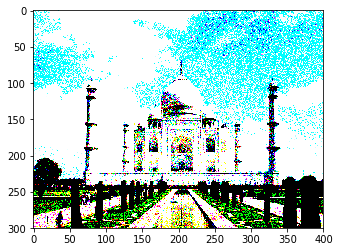

In [21]:
# generate noisy version of the content image
G = noisyImage(C)
imshow(G[0])

#### 5. load pretrained model

In [22]:
# source: matconvnet(vlfeat.org), deeplearning.ai
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [23]:
# load the pretrained model
#model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [24]:
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

#### 6. build the tensorflow graph
   * Run the content image through the model and compute the content cost

In [25]:
# Assign the content image to be the input of the model
sess.run(model['input'].assign(C))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set aC to be the hidden layer activation
aC = sess.run(out)

# Set aG to be the hidden layer activation from the same layer,
# going to execute later when we set input as G and run the session
aG = out

# Compute the content cost
JC = contentCost(aC, aG)

   * Run the style image through the model and compute the style cost

In [26]:
# Assign the input of the model to be the style image 
sess.run(model['input'].assign(S))

# Compute the style cost
JS = weightedStyleCost(model, layerWeights)

   * Compute the total cost

In [27]:
# compute the total cost
J = totalCost(JC, JS, alpha = 10, beta = 40)

   * Define the optimizer and the learning rate

In [28]:
# define optimizer, using 2 as lr
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

#### 7. initialize the tensorflow graph and run it for no. of iterations while updating genrated image G at every step

In [29]:
def saveImage(path, image):
    
    # Un-normalize the image
    image = image + MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [30]:
def modelNST(sess, inputImage, num_iterations = 200):
    """
    Runs the tensorflow graph with input set as inputImage
    
    Arguments:
    sess -- interactive session of a tenserflow graph
    inputImage -- randomaly generated noisy versio of content image
    num_iterations -- number of iterations
    
    Returns:
    G -- final generated image, with contents of Content image and style of the Style image
    """
    
    # Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image through the model
    sess.run(model['input'].assign(inputImage))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        G = sess.run(model['input'])

        # Print every 20 iteration.
        if i%50 == 0:
            Jt, Jc, Js = sess.run([J, JC, JS])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image
            saveImage(str(i) + ".png", G)
    
    # save last generated image
    saveImage('generated_image.jpg', G)
    
    return G

In [31]:
# run to generate the image
Gi = modelNST(sess, G)

Iteration 0 :
total cost = 58680447000.0
content cost = 8307.549
style cost = 1467009200.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 50 :
total cost = 2785613600.0
content cost = 34584.805
style cost = 69631700.0
Iteration 100 :
total cost = 1015392450.0
content cost = 37075.34
style cost = 25375542.0
Iteration 150 :
total cost = 597271900.0
content cost = 38427.68
style cost = 14922191.0


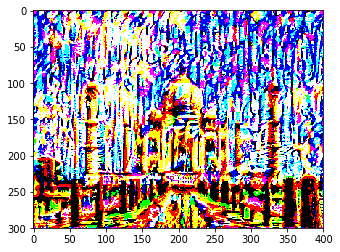

In [32]:
imshow(Gi[0])